C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


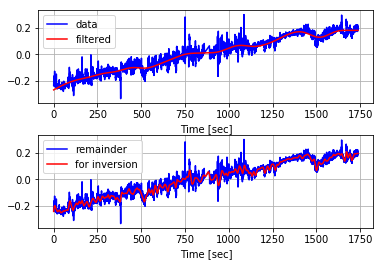

C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


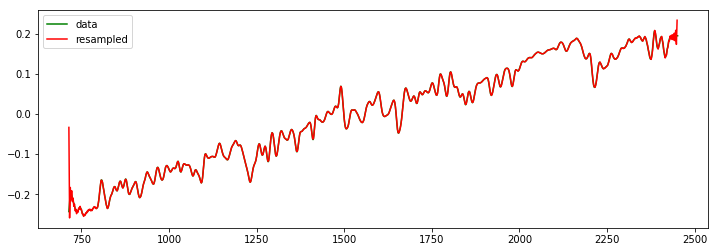

In [168]:
from petrel_well_file_readers import *
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import lasio
from flex_log import FlexXY,FlexLog
from seis_ampl_spectrum import *
folder=r'D:\SoftwareWebApps\Python\geophysics\inversion&spect_decomp\d11_data\\'
# folder=r"D:\Ameyem\python\inversion&spectraldecomp\d11_data\\"
las_file=folder+'nec25_a1.las'
las=lasio.read(las_file)

well_tops_file=folder+'d11_welltops_payzones_220519_sai.dat'
wt=read_welltops(well_tops_file)
wt=wt.sort_values(['MD'])

chkt_file=folder+"nec25_a1_chkt.dat"
chkt=read_chkt(chkt_file)
X=chkt['MD'].values
X.shape=len(X),1
y=chkt['TWT picked'].values
md2twt = LinearRegression().fit(X, y)

las=lasio.read(las_file)
flexlog = FlexLog(np.array([[0,0]]))
x,y=las['DEPT'],las['AI']
x,y=flexlog.get_nonanXYs(x,y)
# plt.plot(x,y)

#seismic trace
from petrel_well_file_readers import *
file=folder+'nec25_a1_NORTH_SEIS.dat'
seis_signal=read_tworowfile(file,nheadrows=2)
seisflexlog = FlexLog(np.column_stack((seis_signal['TWT'],seis_signal['Trace'])))


# 1/(dt/1000)
# fc = 30  # Cut-off frequency of the filter
# w = fc / (fs / 2) # Normalize the frequency

from bruges.filters import ricker as ricker_
FS = 1/0.002
def ricky(length, width):
    return ricker_(0.256, 1/FS, width)

wavelet=ricky(400,20)
dt=2
freq, amp=ampspec(wavelet.T,dt)
f_peak = freq[np.argmax(amp)]
# plot_ampspec(freq,amp,f_peak,name=None)
# import segyio
# from seis_readers import *
# file=folder+'NEC-OSN-97_2_North_crop.sgy'
# sdata, nsamples, sr, stwt, ntraces, header, inlines, crosslines=read_segy(file)

from scipy import signal

md=x
md.shape=len(md),1
twt=md2twt.predict(md)
t=-twt+twt[0]
# plt.plot(twt,y)
# plt.gca().invert_xaxis()
# plt.figure()
# plt.plot(x,y)

dt=np.mean(np.diff(t))
# y.shape=len(y),1
# freq, amp=ampspec(y.T,dt)
# f_peak = freq[np.argmax(amp)]
# plot_ampspec(freq,amp,f_peak,name=None)


nclip=0
# t=-twt[nclip:]+twt[nclip:][0]

# a=np.array([4587.4941406 , 4722.09412164, 4796.70790784])
# a[::-1]
n=len(t)
dt=np.mean(np.diff(t))
T=t[-1]/1000
fs=n/T

t=-twt[nclip:]+twt[nclip:][0]
# data=y[nclip:]
data=y[nclip:]/max(y[nclip:])
data=data-np.mean(data)



fc = 5  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
order=3
b, a = signal.butter(order, w, 'low')
output = signal.filtfilt(b, a, data)
plt.subplot(2, 1, 1)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, output,'r-', label='filtered')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
########################################################
# data=data-output #removing low frequency component
########################################################
fc = 60  # Cut-off frequency of the filter 70 gave 36%, 12.6ms bs
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(order, w, 'low')
ai_for_inv = signal.filtfilt(b, a, data)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='remainder')
plt.plot(t, ai_for_inv,'r-', label='for inversion')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

# x.shape,y.shape,xnew.shape
# present_dt=np.mean(np.diff(x))
# dt=4
# ns=nresamples(y,present_dt,dt)
# ns
# # np.linspace(x[0], x[-1], ns, endpoint=False)
new_tstart=np.ceil(t[0]+(-twt[0]))
if new_tstart%2!=0:
    new_tstart+=1
# new_tstart,-twt[0]
new_tstart-(-twt[0])

from scipy import signal

new_tstart=np.ceil(t[0]+(-twt[0])) # time need to match with seismic time 
if new_tstart%2!=0:
    new_tstart+=1
    

sample_start=new_tstart-(-twt[0])
###############################################################
x,y=t,ai_for_inv #making removed high frequency signal as main
# x,y=t,data
###############################################################
# x = np.linspace(0, 10, 20, endpoint=False)
# y = np.cos(-x**2/6.0)
def nresamples(x,present_dt,req_dt):
    return int(len(x) / (req_dt * present_dt))
def myresample(x,y,sample_start=0,dt=4):
    xnew=np.arange(sample_start,x[-1]+0.001,dt)
    res_y = signal.resample(y, len(xnew))
    return xnew,res_y

import matplotlib.pyplot as plt
tnew,ai_res=myresample(x,y,dt=2)
tnew=tnew+new_tstart
x=x+new_tstart
plt.figure(figsize=(12,4))
# plt.plot(t, data, 'y-')
plt.plot(x, y, 'g-', tnew, ai_res, 'r-')
# plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()


# dt=2
# freq, amp=ampspec(ai_res.T,dt)
# f_peak = freq[np.argmax(amp)]
# plot_ampspec(freq,amp,f_peak,name=None)

[]


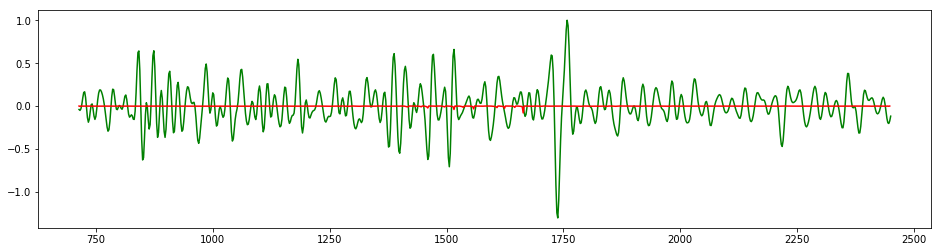

In [169]:

# print(stwt[[0,-1]],tnew[[0,-1]])

# tnew+(-twt[0])

seis_resamp=seisflexlog.resampleXYs(tnew)
seis_resamp[:,1]=seis_resamp[:,1]/np.max(seis_resamp[:,1])

plt.figure(figsize=(16,4))
plt.plot(seis_resamp[:,0], seis_resamp[:,1], 'g-', label='remainder') #, xnew, f, 'r-'
rc=(ai_res[1:]-ai_res[:-1])/(ai_res[1:]+ai_res[:-1])
comp_val=2
# inds=rc>comp_val
# rc[inds]=comp_val
# inds=rc<-comp_val
# rc[inds]=-comp_val
rc=rc/np.max(rc)
rc[rc>np.mean(rc)]=np.mean(rc)
# plt.plot(rc)
print(rc[np.abs(rc)>comp_val-1])
plt.plot( tnew[:-1], 1*rc, 'r-')



In [164]:
# ai_res[1:]-ai_res[:-1]

[[ 1.         -0.02501737]
 [-0.02501737  1.        ]]


C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


<Figure size 432x288 with 0 Axes>

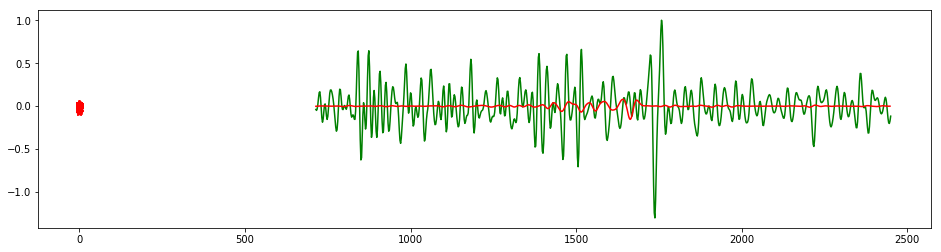

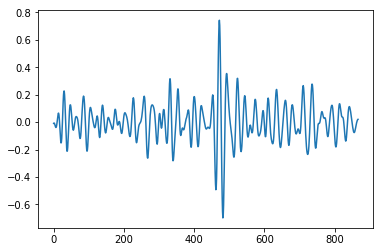

In [170]:
recorded = signal.convolve(wavelet, rc)
synth=recorded[int(len(wavelet)/2):1-int(len(wavelet)/2)]
plt.figure()
# plt.plot(rc)
# plt.plot(synth)
# plt.figure()
# plt.plot(wavelet)


plt.figure(figsize=(16,4))
plt.plot(seis_resamp[:,0], seis_resamp[:,1], 'g-', label='remainder') #, xnew, f, 'r-'
plt.plot( tnew[:-1], 2*synth, 'r-')

plt.plot( seis_resamp[:-1,1], synth, 'r*')
plt.figure()
corr = signal.correlate(seis_resamp[:-1,1], synth, mode='same') 
plt.plot(corr)
print(np.corrcoef( seis_resamp[:-1,1], 0.1*synth))

38 4.154265989659747
[[1.         0.37832118]
 [0.37832118 1.        ]]


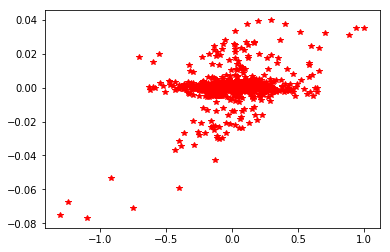

In [171]:
corr = signal.correlate(seis_resamp[:-1,1], synth, mode='same') 
nsamp=int(np.argmax(corr)-len(corr)/2)
if nsamp>0:
    real_seis,synth_seis=np.append(seis_resamp[:-1,1],np.zeros(nsamp)), np.append(np.zeros(nsamp),synth)
else:
    real_seis,synth_seis=np.append(np.zeros(-nsamp),seis_resamp[:-1,1]), np.append(synth,np.zeros(-nsamp))
corr = signal.correlate(real_seis,synth_seis, mode='same') 
# plt.plot(corr)
print(nsamp,nsamp*dt)
plt.plot( real_seis,synth_seis, 'r*')
dt*(np.argmax(corr)-len(corr)/2)
print(np.corrcoef( real_seis,0.1*synth_seis))

[[1.        0.2139776]
 [0.2139776 1.       ]]


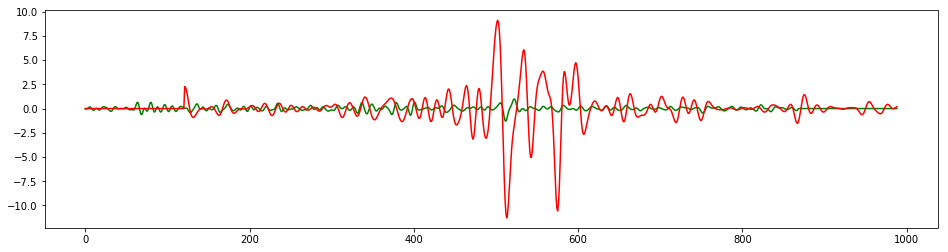

In [80]:
plt.figure(figsize=(16,4))

plt.plot(real_seis, 'g-', label='real_seis') #, xnew, f, 'r-'
plt.plot(4*synth_seis, 'r-')

In [161]:
# import numpy as np
# from scipy.signal import butter, lfilter, freqz
# import matplotlib.pyplot as plt
# %matplotlib inline

# def butter_lowpass(cutoff, fs, order=5):
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     return b, a

# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     b, a = butter_lowpass(cutoff, fs, order=order)
#     y = lfilter(b, a, data)
#     return y
# # T = 5.0         # seconds
# # n = int(T * fs) # total number of samples
# # t = np.linspace(0, T, n, endpoint=False)
# nclip=300
# t=-twt[nclip:]+twt[nclip:][0]
# data=y[nclip:]/max(y[nclip:])
# data=data-np.mean(data)

# n=len(t)
# dt=np.mean(np.diff(t))
# T=t[-1]/1000
# fs=n/T
# cutoff = 12
# order = 6


# # Filter the data, and plot both the original and filtered signals.
# fy = butter_lowpass_filter(data, cutoff, fs, order)
# plt.subplot(2, 1, 1)
# plt.plot(t, data, 'b-', label='data')
# plt.plot(t, fy, 'g-', linewidth=2, label='filtered data')
# plt.xlabel('Time [sec]')
# plt.grid()
# plt.legend()

# data=data-fy
# plt.subplot(2, 1, 2)
# plt.plot(t, data, 'b-', label='data')
# plt.xlabel('Time [sec]')
# plt.grid()
# plt.legend()

# plt.subplots_adjust(hspace=0.35)
# plt.show()